Number of coregistered control sessions: 326


,participant_id,session,group,age,coregistration,coreg_confidence
0,sub-0001,ses-01,Control,42.78,Yes,2.0
3,sub-0002,ses-02,Control,23.26,Yes,1.0
7,sub-0003,ses-02,Control,35.13,Yes,2.0
11,sub-0004,ses-02,Control,27.42,Yes,2.0
13,sub-0006,ses-01,Control,30.29,Yes,2.0


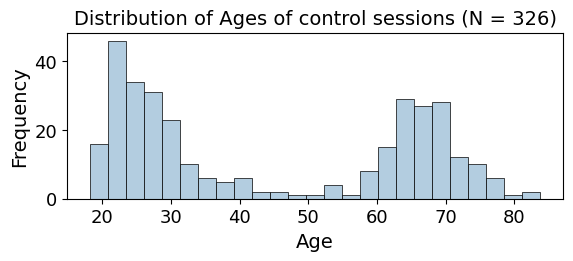

In [5]:
import os
import pandas as pd
import subprocess
# Set the session file path
DOWNLOAD_FILES = False # if True, download the file from omega using rclone
# Set the full path to "rclone" binary, need to download appropriate version for your system
rclone_path = '/Users/dennis.jungchildmind.org/Downloads/rclone-v1.72.1-osx-arm64/rclone'
# Set your preferred root target directory for downloads 
target_base_dir = "/Users/dennis.jungchildmind.org/Downloads/test/"  # or set to any path you want
# "sessions.tsv", which contains subject information, from the omega dataset repository
session_file = 'sessions_from_omega_dataset.tsv' 
sessions = pd.read_csv(os.path.join(session_file), sep='\t')

# Filter sessions: only coregistered control sessions, other data without coregistration cannot be used
coregistered_control_sessions = sessions[
    (sessions['coregistration'].str.lower() == 'yes') &
    (sessions['group'].str.lower() == 'control')
]

# Display the number of coregistered control sessions
print(f"Number of coregistered control sessions: {len(coregistered_control_sessions)}")

# Show first few rows (optional, for preview)
display(coregistered_control_sessions.head())

# Plot distribution of ages
ax = coregistered_control_sessions['age'].hist(
    bins=25, 
    grid=False, 
    edgecolor='black',
    facecolor='#b3cde0',  # pastel blue
    linewidth=0.5
)
ax.set_xlabel('Age', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title(
    f'Distribution of Ages of control sessions (N = {len(coregistered_control_sessions)})',
    fontsize=14
)
ax.tick_params(axis='both', labelsize=13)
ax.set_aspect(aspect=1/2)


In [ ]:
#This function was used to specify the control sessions and download manually in test stage
def select_control_sessions(coregistered_sessions, group='young', max_samples=40, random_state=67):
    """
    Randomly select up to `max_samples` control sessions from the coregistered sessions,
    based on group ('young' or 'old') criteria.

    Args:
        coregistered_sessions (pd.DataFrame): DataFrame of control sessions.
        group (str): 'young' for sessions with age < 40, 'old' for participant_id containing 'CONP' and typically age > 50
        max_samples (int): Maximum number of sessions to select.
        random_state (int): Random state for reproducible sampling.

    Returns:
        pd.DataFrame: Sampled control sessions.
    """
    if group == 'young':
        filtered_sessions = coregistered_sessions[coregistered_sessions['age'] < 30]
    else:
        filtered_sessions = coregistered_sessions[
            coregistered_sessions['participant_id'].str.contains('CONP')
        ]

    n_to_sample = min(max_samples, len(filtered_sessions))
    if n_to_sample == 0:
        raise ValueError(f"No control sessions found for group criteria: {group_desc}")

    sampled_sessions = filtered_sessions.sample(n=n_to_sample, random_state=random_state).copy()
    return sampled_sessions

group = 'young' # choose group: 'young' or 'old'
control_sessions = select_control_sessions(coregistered_control_sessions, group=group)

In [8]:
#NOTE THIS SECTION IS TO DOWNLOAD THE OMEGA DATASET.
#THIS REQUIRES DATA ACCESS TO THE OMEGA DATASET AND SETUP RCLONE IN THE SYSTEM.

def list_remote_files(rclone_path, remote_base):
    """List all files under a remote directory using rclone."""
    cmd_ls = f'"{rclone_path}" ls {remote_base}'
    print(f"Listing files: {cmd_ls}")
    result = subprocess.run(cmd_ls, shell=True, check=True, capture_output=True, text=True)
    lines = [
        line.strip().split(maxsplit=1)[1]
        for line in result.stdout.strip().split('\n')
        if len(line.strip().split(maxsplit=1)) == 2
    ]
    return lines

def download_file(rclone_path, remote_file_path, local_file_path, filetype_desc):
    """Download a remote file to a local path, creating the directory if needed."""
    local_file_dir = os.path.dirname(local_file_path)
    os.makedirs(local_file_dir, exist_ok=True)
    print(f"[DOWNLOAD] Downloading {filetype_desc}:\n"
          f"  Remote file: {remote_file_path}\n"
          f"  To local: {local_file_path}")
    cmd_copy = f'"{rclone_path}" copyto "{remote_file_path}" "{local_file_path}"'
    print(f"  Running: {cmd_copy}")
    subprocess.run(cmd_copy, shell=True, check=True)

def download_subject_files(sub_id, rclone_path, target_base_dir, nii_gz_paths, t1w_json_paths):
    remote_base = f"omega:Omega/{sub_id}"
    lines = list_remote_files(rclone_path, remote_base)
    found_any = False
    found_any_json = False

    for remote_file in lines:
        remote_file_path = f"{remote_base}/{remote_file}"
        local_file_path = os.path.join(target_base_dir, sub_id, remote_file)
        
        if remote_file.endswith('.nii.gz'):
            found_any = True
            nii_gz_paths.append(remote_file_path)
            download_file(rclone_path, remote_file_path, local_file_path, 'nii.gz')
        
        if remote_file.endswith('_T1w.json'):
            found_any_json = True
            t1w_json_paths.append(remote_file_path)
            download_file(rclone_path, remote_file_path, local_file_path, '_T1w.json')
    
    if not found_any:
        print(f"[CHECK] No nii.gz found for subject {sub_id}")
    if not found_any_json:
        print(f"[CHECK] No _T1w.json found for subject {sub_id}")

def print_downloaded_paths(title, paths):
    print(title)
    for path in paths:
        print(path)

if DOWNLOAD_FILES:
    nii_gz_paths = []   # Will store all remote paths to .nii.gz
    t1w_json_paths = [] # Will store all remote paths to _T1w.json

    for idx, row in coregistered_control_sessions.iterrows():
        sub_id = row['participant_id']
        download_subject_files(sub_id, rclone_path, target_base_dir, nii_gz_paths, t1w_json_paths)

    print_downloaded_paths("All downloaded .nii.gz remote paths:", nii_gz_paths)
    print_downloaded_paths("All downloaded _T1w.json remote paths:", t1w_json_paths)